[View in Colaboratory](https://colab.research.google.com/github/adifatol/BIQA/blob/master/BIQA.ipynb)

In [1]:
!ls jpeg

ls: cannot access 'jpeg': No such file or directory


# Upload Images

shows a dialog to upload new images

option to download the CSIQ Image Quality Database

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [3]:
!wget http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
!wget http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip
  
!unzip src_imgs.zip
!unzip dst_imgs.zip

--2018-08-10 13:35:18--  http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14455692 (14M) [application/zip]
Saving to: ‘src_imgs.zip’

src_imgs.zip        100%[===================>]  13.79M  6.97MB/s    in 2.0s    

2018-08-10 13:35:21 (6.97 MB/s) - ‘src_imgs.zip’ saved [14455692/14455692]

--2018-08-10 13:35:22--  http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374383009 (357M) [application/zip]
Saving to: ‘dst_imgs.zip’

dst_imgs.zip        100%[===================>] 357.04M  11.2MB/s    in 33s     

2018-08-10 1

# Load Images in colab

loads images of a certain SHAPE into runtime memory

In [4]:

# Load the images
# Encode them into jpg

DISTORT = ['blur','contrast','fnoise', 'jpeg', 'jpeg2000']
DISTORT_EXT = ['BLUR','contrast','fnoise', 'JPEG', 'jpeg2000']
Q_LEVELS = ['1','2','3','4','5']

from random import randint
import numpy as np
import cv2
import os

def load_imgs():
  images = {}
  images['orig'] = []
  for dist in DISTORT:
    images[dist] = {}
    for qlvl in Q_LEVELS:
      images[dist][qlvl] = []

  for f in [file for file in os.listdir() if file.endswith('.png')]:
    fname = os.path.splitext(f)[0]
    img_data = cv2.imread(f)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    images['orig'].append(img_data)
    for dist, d_ext in zip(DISTORT, DISTORT_EXT):
      for qlvl in Q_LEVELS:
        f_path = dist+'/'+fname+'.'+d_ext+'.'+qlvl+'.png'
        img_data = cv2.imread(f_path)
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        images[dist][qlvl].append(img_data)
  return images

images = load_imgs()

print("Nr of img:",len(images['orig']))


Nr of img: 30


In [0]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_all(arr_of_images, patch_estimator=False):
  columns = 5
  spacing = 14.75
  minorLocator = MultipleLocator(spacing)
  fig = plt.figure(figsize=(40,20))
  for i, image in enumerate(arr_of_images):
    ax = fig.add_subplot(len(images) / columns + 1, columns, i + 1)
    if patch_estimator:
      ax.yaxis.set_minor_locator(minorLocator)
      ax.xaxis.set_minor_locator(minorLocator)
      ax.grid(which = 'minor')
    plt.imshow(image)
  plt.show()


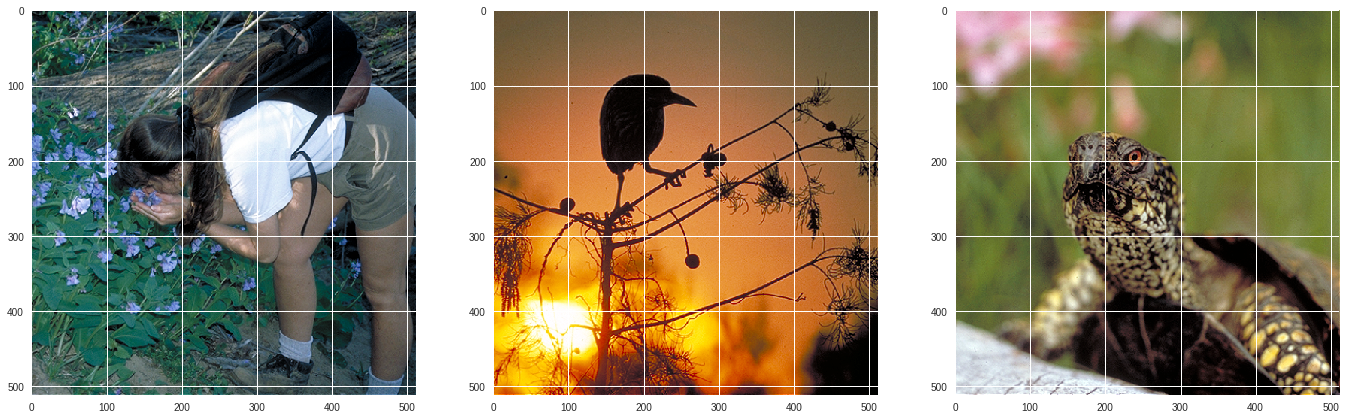

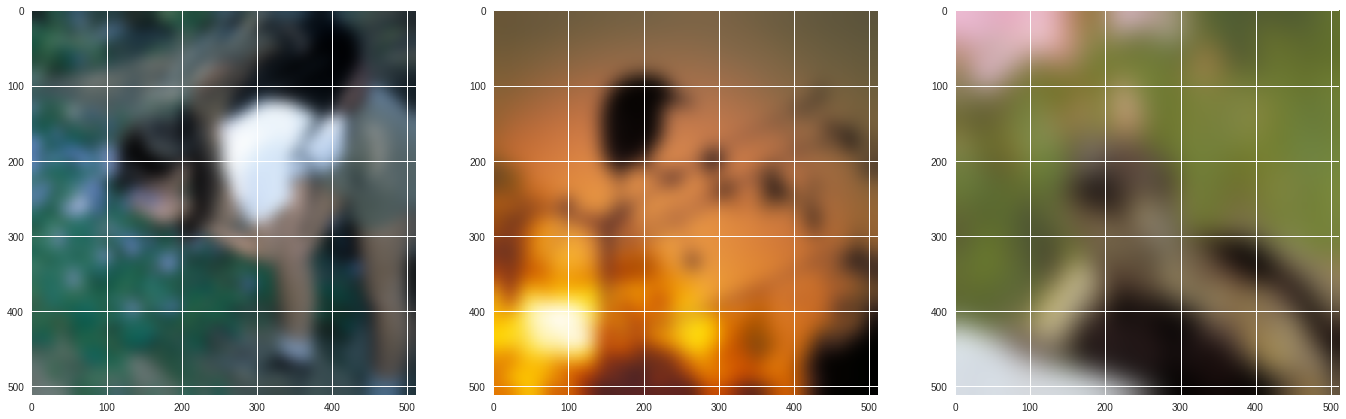

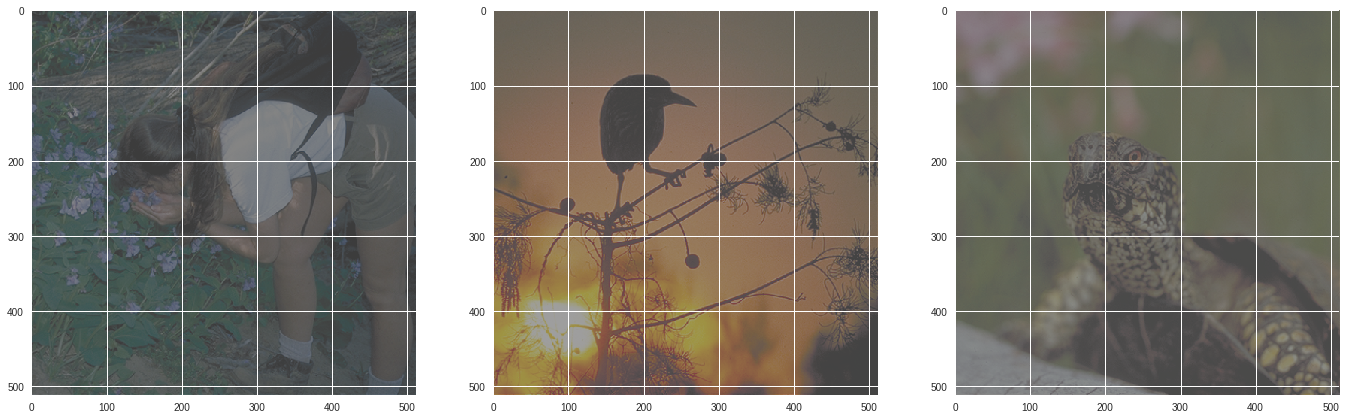

In [6]:
#Print some stats

rand_idx = randint(0, len(images['orig'])-3)
plot_all(images['orig'][rand_idx:rand_idx+3])
plot_all(images['blur']['5'][rand_idx:rand_idx+3])
plot_all(images['contrast']['5'][rand_idx:rand_idx+3])


# Score Images

apply the method suggested in [Learning without Human Scores for Blind Image Quality Assessment](https://www.cv-foundation.org/openaccess/content_cvpr_2013/papers/Xue_Learning_without_Human_2013_CVPR_paper.pdf)

## Extract Patches and calculate {SSIM} score

In [7]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.5MB/s 


In [8]:
from skimage.measure import compare_ssim
from skimage.util.shape import view_as_windows
from tqdm import tqdm

WH=15
WINDOW_SHAPE = (WH,WH,3)
PATCH_COUNT = 1156 #TODO this should be automated somehow

def plot_patches(patches):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 1
  rows = 1
  for i in range(1, columns*rows +1):
      img = patches[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

def extract_patches(img):
  patches = np.squeeze(view_as_windows(img, WINDOW_SHAPE,step=WH))
  patches = np.reshape(patches,(-1,15,15,3))
  return patches

dim_len, dim_dist, dim_q = len(images['orig']), len(DISTORT), len(Q_LEVELS);
test_len = dim_len

one_score = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
scores = [np.copy(one_score) for x in range(test_len)]

for i in tqdm(range(len(images['orig'][:test_len]))):
  img = images['orig'][i]
  orig_patches = extract_patches(img)
  for idist, dist in enumerate(DISTORT):
    for iqlvl, qlvl in enumerate(Q_LEVELS):
      dist_img = images[dist][qlvl][i]
      distorted_patches = extract_patches(dist_img)
      local_scores = np.zeros(PATCH_COUNT)
      for j in range(PATCH_COUNT):
        orig_patch = orig_patches[j]
        dist_patch = distorted_patches[j]
        (score, diff) = compare_ssim(orig_patch, dist_patch, full=True, multichannel=True)
        local_scores[j] = score
      scores[i][idist][iqlvl] = np.copy(local_scores)

#   plot_patches(orig_patches)
#   for patch in orig_patches:
#   (score, diff) = compare_ssim(dist_img, img, full=True, multichannel=True)
#   diff = (diff * 255).astype("uint8")
#   print("___")
#   print("SSIM: {}".format(score))


100%|██████████| 30/30 [11:30<00:00, 23.00s/it]


## Calculate the C constant (![alt text](https://latex.codecogs.com/gif.latex?c%20%3D%20%5Cfrac%7B%5Csum%20_%7Bi%5Cepsilon%20%5COmega%7DS_%7Bi%7D%20%7D%7B10*%5Csum%20_%7Bi%5Cepsilon%20%5COmega_%7Bp%7D%7DS_%7Bi%7D%7D))

In [0]:
def the_C_constant(batch):
  all_sum = sum(batch)
  percentile10 = np.percentile(batch,10)
  omega_p_sum = sum([i for i in batch if i <= percentile10])
  c = all_sum / (10 * omega_p_sum)
  return c
# the_C_constant(scores[0][0][0])

## Histograms for scores

(30, 5, 5, 1156)
1.7364193092129792
comparing for 25
(img-25 dist-4 qual-3)
[0.70160907 0.68883442 0.74449528 ... 0.33200372 0.7968724  0.64690929]


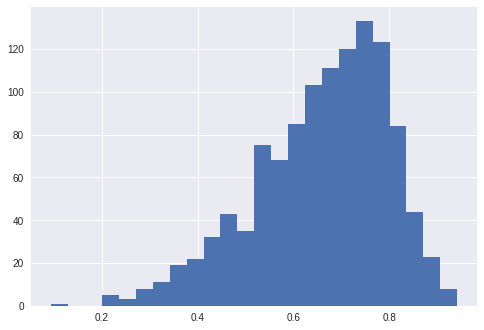

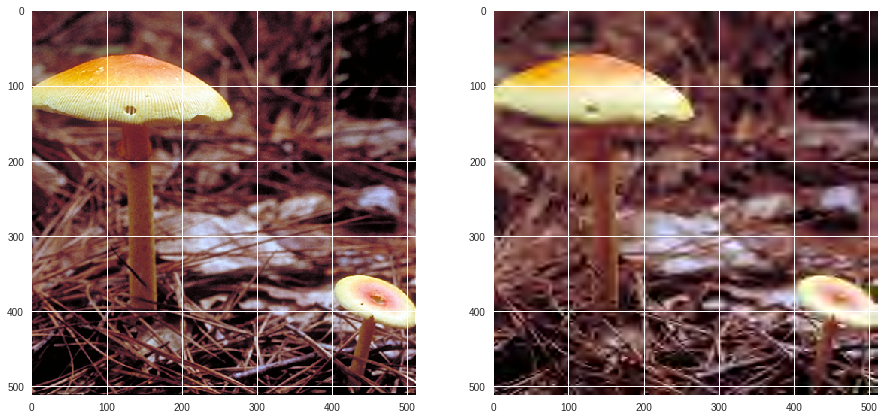

In [74]:
#Random scores visualisations

from mpl_toolkits.mplot3d import Axes3D

def histogram(img_idx, img_dist, img_qual):
  print("comparing for {}".format(img_idx))
  print("(img-{} dist-{} qual-{})".format(img_idx, img_dist, img_qual))
  print(scores[img_idx][img_dist][img_qual])
  plt.hist(scores[img_idx][img_dist][img_qual], bins='auto')
  plt.show()

ri = randint(0,dim_len-1)
rd = randint(0,dim_dist-1)
rq = randint(0,dim_q-1)

print(np.array(scores).shape)

for i in range(ri,ri+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      c = the_C_constant(scores[i][d][q])
      print(c)
      histogram(ri,rd,rq)
      plot_all([images['orig'][i],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])


## Normalize scores

In [0]:
norm_scores = np.copy(scores)
for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
      c = the_C_constant(scores[i][d][q])
      norm_scores[i][d][q][:] = [x / c for x in norm_scores[i][d][q]]


(img-25 dist-jpeg2000 qual-4)


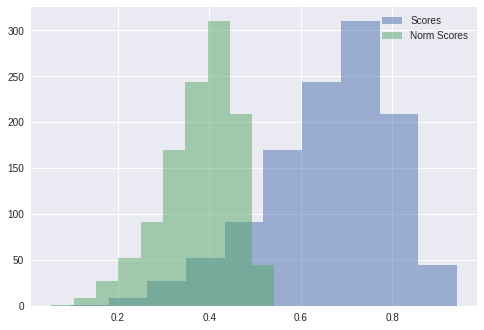

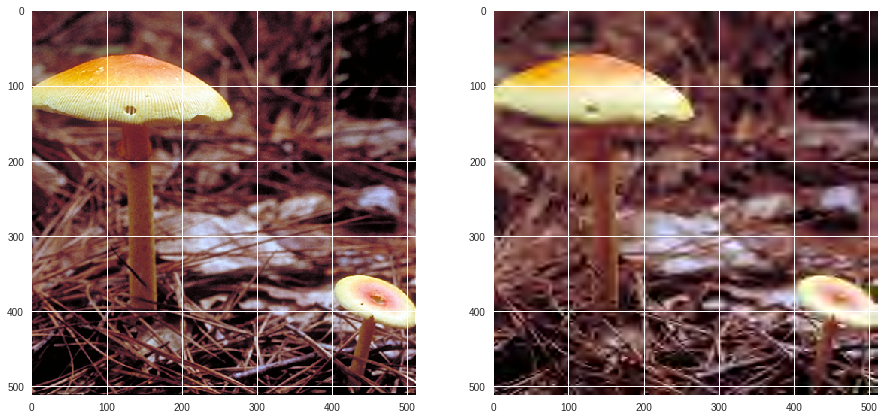

In [76]:
print("(img-{} dist-{} qual-{})".format(ri, DISTORT[rd], Q_LEVELS[rq]))

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.legend(loc='upper right')
plt.show()

plot_all([images['orig'][ri],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])

## Score QAC - Quality Aware Clusters

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
(30, 5, 5, 1156)
(30, 5, 5, 1156)


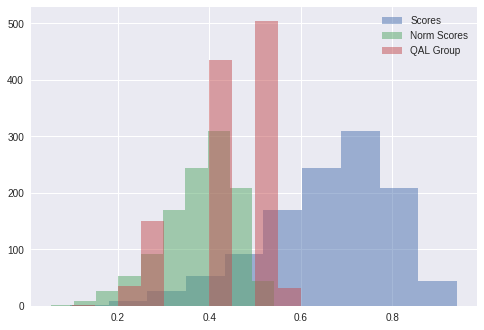

In [82]:
# Define The Score Levels used in QAC

L = 10
Gl = list(range(1,L+1))
Gl[:] = [x / L for x in Gl]


one_group = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
G = [np.copy(one_group) for x in range(dim_len)]

print(Gl)
print(np.array(G).shape)
print(np.array(norm_scores).shape)

# for i in range(0,dim_len):
#   for d in range(0,dim_dist):
#     for q in range(0,dim_q):
for i in range(ri,i+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      for p,score in enumerate(norm_scores[i][d][q]):
        for score_l in Gl:
          if score <= score_l:
            G[i][d][q][p] = score_l
            break

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.hist(G[ri][rd][rq], alpha=0.5, label='QAL Group')
plt.legend(loc='upper right')
plt.show()